<a href="https://colab.research.google.com/github/Orasz/CNN4COVID19/blob/main/resnetConfusionMatrixFinal" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode
print("done")

done


In [5]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms_xray = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
        'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'gdrive/MyDrive/datasetQaTa/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms_xray[x])
                  for x in ['train', 'val']}
#aumenta batch size 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print("Dataset sizes: {}".format(dataset_sizes))
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using device: {}".format(device))




Dataset sizes: {'train': 7375, 'val': 940}
using device: cuda:0


In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        t1 = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            t2 = time.time()
            print('time:{}'.format(t2-t1))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

print("done")

done


In [7]:
#preparing dataloader for test
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms_xray[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
print(dataset_sizes)

{'train': 7375, 'val': 940, 'test': 912}


In [8]:
def printcm(model):
  confusion_matrixx = torch.zeros(2, 2)
  with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrixx[t.long(), p.long()] += 1

  print(confusion_matrixx)
  return confusion_matrixx

In [9]:
#Dropout added in FC Layer, should it be added between each Conv.Layer as well/instead?
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
print(model_ft.fc)
print(num_ftrs)
 
#custom classifier layer for binary classification
#Activation function used but results are the same with or without it.
#It should be noted that in Library/Pytorch implementation of ResNet 50 the output of the fc layer is the final output, without calling softMax on it.
model_ft.fc = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(512,2)
)
print("Fully connected layer after optimization:")
print(model_ft.fc)
model_ft = model_ft.to(device)

#CrossEntropyLoss works well, but for segmentation maybe FocalLoss is better
criterion = nn.CrossEntropyLoss()

#Settin learning reate to 10^-5, it should make the learning process more stable
optimizer_adam = optim.Adam(model_ft.parameters(), lr=0.00001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_adam, step_size=7, gamma=0.1)
print("done")

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Linear(in_features=2048, out_features=1000, bias=True)
2048
Fully connected layer after optimization:
Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Linear(in_features=2048, out_features=1024, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=512, out_features=2, bias=True)
)
done


In [10]:
model_ft = train_model(model_ft, criterion, optimizer_adam, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.2144 Acc: 0.9241
time:516.0880224704742
val Loss: 0.0483 Acc: 0.9819
time:584.7886011600494

Epoch 1/9
----------
train Loss: 0.0455 Acc: 0.9845
time:85.17779922485352
val Loss: 0.0413 Acc: 0.9840
time:90.34135866165161

Epoch 2/9
----------
train Loss: 0.0158 Acc: 0.9946
time:84.91285705566406
val Loss: 0.0420 Acc: 0.9872
time:90.01942467689514

Epoch 3/9
----------
train Loss: 0.0130 Acc: 0.9959
time:84.82807421684265
val Loss: 0.0311 Acc: 0.9894
time:89.95633554458618

Epoch 4/9
----------
train Loss: 0.0077 Acc: 0.9976
time:84.63842701911926
val Loss: 0.0538 Acc: 0.9809
time:89.7621762752533

Epoch 5/9
----------
train Loss: 0.0127 Acc: 0.9972
time:84.75823664665222
val Loss: 0.0559 Acc: 0.9787
time:89.78775191307068

Epoch 6/9
----------
train Loss: 0.0049 Acc: 0.9984
time:84.41618871688843
val Loss: 0.0377 Acc: 0.9872
time:89.49421977996826

Epoch 7/9
----------
train Loss: 0.0021 Acc: 0.9995
time:84.83736228942871
val Loss: 0.0769 Acc: 0.9787
t

In [11]:
#Save model to avoid training every time
model_ft_save_name = 'resnet10epochs.pt'
path = 'gdrive/MyDrive/models/{model_ft_save_name}'
torch.save(model_ft.state_dict(), path)

In [ ]:
#Code to load the model
model_ft_save_name = 'resnet10epochs.pt'
path = F"/content/gdrive/My Drive/{model_ft_save_name}"
model.load_state_dict(torch.load(path))

In [14]:
cm = printcm(model_ft)



tensor([[454.,   2.],
        [  0., 456.]])


In [20]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
tensor([[454.,   2.],
        [  0., 456.]])


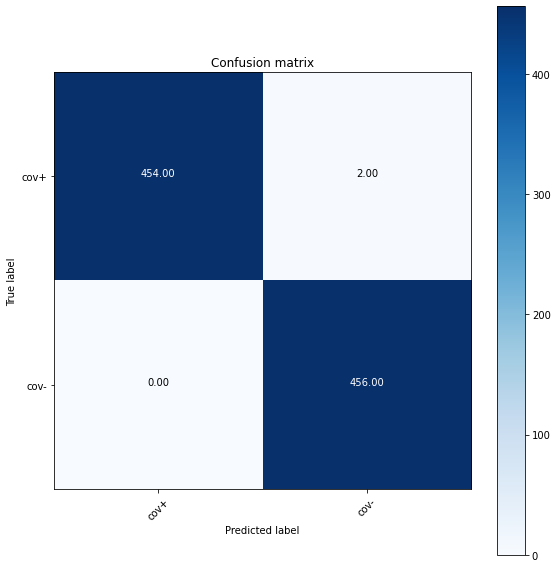

In [22]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm,image_datasets['test'].classes)